# Справочник

## Токенизатор

Токенизатор в Yargy реализован на регулярных выражениях. Для каждого типа токена есть правило с регуляркой:

In [1]:
from yargy.tokenizer import RULES


RULES

[TokenRule(
     type='RU',
     pattern='[а-яё]+'
 ),
 TokenRule(
     type='LATIN',
     pattern='[a-z]+'
 ),
 TokenRule(
     type='INT',
     pattern='\\d+'
 ),
 TokenRule(
     type='PUNCT',
     pattern='[-\\\\/!#$%&()\\[\\]\\*\\+,\\.:;<=>?@^_`{|}~№…"\\\'«»„“ʼʻ”]'
 ),
 TokenRule(
     type='EOL',
     pattern='[\\n\\r]+'
 ),
 TokenRule(
     type='OTHER',
     pattern='\\S'
 )]

Токенизатор инициализируется списком правил. По-умолчанию — это `RULES`:

In [2]:
from yargy.tokenizer import Tokenizer


text = 'a@mail.ru'
tokenizer = Tokenizer()
list(tokenizer(text))

[Token(
     value='a',
     span=[0, 1),
     type='LATIN'
 ),
 Token(
     value='@',
     span=[1, 2),
     type='PUNCT'
 ),
 Token(
     value='mail',
     span=[2, 6),
     type='LATIN'
 ),
 Token(
     value='.',
     span=[6, 7),
     type='PUNCT'
 ),
 Token(
     value='ru',
     span=[7, 9),
     type='LATIN'
 )]

Пользователь может убрать часть правил из списка или добавить новые. Уберём токены с переводами строк:

In [3]:
tokenizer = Tokenizer()

text = '''
abc
123
'''
list(tokenizer(text))

[Token(
     value='\n',
     span=[0, 1),
     type='EOL'
 ),
 Token(
     value='abc',
     span=[1, 4),
     type='LATIN'
 ),
 Token(
     value='\n',
     span=[4, 5),
     type='EOL'
 ),
 Token(
     value='123',
     span=[5, 8),
     type='INT'
 ),
 Token(
     value='\n',
     span=[8, 9),
     type='EOL'
 )]

Для этого удалим правило `EOL`:

In [4]:
tokenizer = Tokenizer().remove_types('EOL')

list(tokenizer(text))

[Token(
     value='abc',
     span=[1, 4),
     type='LATIN'
 ),
 Token(
     value='123',
     span=[5, 8),
     type='INT'
 )]

В Yargy есть примитивные правила для токенизации емейлов и телефонов. По-умолчанию они отключены:

In [5]:
from yargy.tokenizer import EMAIL_RULE, PHONE_RULE


text = 'email: ab@mail.ru call: 8 915 132 54 76'
tokenizer = Tokenizer().add_rules(EMAIL_RULE, PHONE_RULE)
list(tokenizer(text))

[Token(
     value='email',
     span=[0, 5),
     type='LATIN'
 ),
 Token(
     value=':',
     span=[5, 6),
     type='PUNCT'
 ),
 Token(
     value='ab@mail.ru',
     span=[7, 17),
     type='EMAIL'
 ),
 Token(
     value='call',
     span=[18, 22),
     type='LATIN'
 ),
 Token(
     value=':',
     span=[22, 23),
     type='PUNCT'
 ),
 Token(
     value=' 8 915 132 54 76',
     span=[23, 39),
     type='PHONE'
 )]

Добавим собственное для извлечения доменов:

In [6]:
from yargy.tokenizer import TokenRule


DOMAIN_RULE = TokenRule('DOMAIN', '[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+')

    
text = 'на сайте www.VKontakte.ru'
tokenizer = Tokenizer().add_rules(DOMAIN_RULE)
list(tokenizer(text))

[Token(
     value='на',
     span=[0, 2),
     type='RU'
 ),
 Token(
     value='сайте',
     span=[3, 8),
     type='RU'
 ),
 Token(
     value='www.VKontakte.ru',
     span=[9, 25),
     type='DOMAIN'
 )]

По умолчанию, Yargy использует не `Tokenizer`, а `MorphTokenizer`. Для каждого токена с типом `'RU'` он запускает Pymorphy2, добавляет поле `forms` с морфологией:

In [7]:
from yargy.tokenizer import MorphTokenizer

tokenizer = MorphTokenizer()
list(tokenizer('X век стал'))

[Token(
     value='X',
     span=[0, 1),
     type='LATIN'
 ),
 MorphToken(
     value='век',
     span=[2, 5),
     type='RU',
     forms=[Form('век', Grams(NOUN,inan,masc,nomn,sing)),
      Form('век', Grams(NOUN,accs,inan,masc,sing)),
      Form('век', Grams(ADVB)),
      Form('веко', Grams(NOUN,gent,inan,neut,plur))]
 ),
 MorphToken(
     value='стал',
     span=[6, 10),
     type='RU',
     forms=[Form('стать', Grams(VERB,indc,intr,masc,past,perf,sing))]
 )]

## Газеттир

Словарь профессий, географических объектов можно записывать стандартные средствами через `rule`, `or_`, `normalized`, `caseless`:

In [8]:
from yargy import rule, or_
from yargy.predicates import normalized, caseless


POSITION = or_(
    rule(normalized('генеральный'), normalized('директор')),
    rule(normalized('бухгалтер'))
)

GEO = or_(
    rule(normalized('Ростов'), '-', caseless('на'), '-', caseless('Дону')),
    rule(normalized('Москва'))
)

Это неудобно, легко ошибиться. Для составления словарей в Yargy используется `pipeline`. Реализовано два типа газеттиров: `morph_pipeline` и `caseless_pipeline`. `morph_pipeline` перед работой приводит слова к нормальной форме:

In [9]:
from yargy import Parser
from yargy.pipelines import morph_pipeline


TYPE = morph_pipeline(['электронный дневник'])

parser = Parser(TYPE)
text = 'электронным дневником, электронные дневники, электронное дневнику'
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['электронным', 'дневником']
['электронные', 'дневники']
['электронное', 'дневнику']


`caseless_pipeline` ищет слова без нормализации. Например, найдём в тексте арабские имена: "Абд Аль-Азиз Бин Мухаммад", "Абд ар-Рахман Наср ас-Са ди": 

In [10]:
from yargy.pipelines import caseless_pipeline


NAME = caseless_pipeline([
    'Абд Аль-Азиз Бин Мухаммад',
    'Абд ар-Рахман Наср ас-Са ди'
])
    
parser = Parser(NAME)
text = 'Абд Аль-Азиз Бин Мухаммад, АБД АР-РАХМАН НАСР АС-СА ДИ'
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['Абд', 'Аль', '-', 'Азиз', 'Бин', 'Мухаммад']
['АБД', 'АР', '-', 'РАХМАН', 'НАСР', 'АС', '-', 'СА', 'ДИ']


## Предикаты

In [11]:
from IPython.display import HTML

from yargy.predicates import bank

def html():
    for name in bank.__all__:
        yield f'<h3>{name} <a name="predicates.{name}"><a href="#predicates.{name}">#</a></h3>'
        doc = getattr(bank, name).__doc__.strip()
        yield f'<br/><pre>    {doc}</pre>'

HTML('\n'.join(html()))

## Интерпретация

Объект-результат интерпретации описывает конструктор `fact`. `attribute` задаёт значение поля по-умолчанию. Например, в `Date` по-умолчанию год будет равен 2017:

In [12]:
from IPython.display import display

from yargy import Parser, rule, and_, or_
from yargy.interpretation import fact, attribute
from yargy.predicates import dictionary, gte, lte


Date = fact(
    'Date',
    [attribute('year', 2017), 'month', 'day']
)


MONTHS = {
    'январь',
    'февраль',
    'март',
    'апрель',
    'мая',
    'июнь',
    'июль',
    'август',
    'сентябрь',
    'октябрь',
    'ноябрь',
    'декабрь'
}


MONTH_NAME = dictionary(MONTHS)
DAY = and_(
    gte(1),
    lte(31)
)
YEAR = and_(
    gte(1900),
    lte(2100)
)
DATE = rule(
    DAY.interpretation(
        Date.day
    ),
    MONTH_NAME.interpretation(
        Date.month
    ),
    YEAR.interpretation(
        Date.year
    ).optional()
).interpretation(
    Date
)


text = '''18 июля 2016
15 марта
'''
parser = Parser(DATE)
for line in text.splitlines():
    match = parser.match(line)
    display(match.fact)

Date(
    year='2016',
    month='июля',
    day='18'
)

Date(
    year=2017,
    month='марта',
    day='15'
)

Для дат деревья разбора выглядят просто: вершина-конструктор и несколько детей-атрибутов:

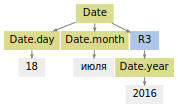

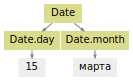

In [13]:
parser = Parser(DATE)
for line in text.splitlines():
    match = parser.match(line)
    display(match.tree.as_dot)

Как будет себя вести алгоритм интерпретации, когда ребёнок конструктора не атрибут, а другой конструктор? Или когда ребёнок атрибута другой атрибут? Или когда под конструктором или атрибутом не одна, а несколько вершин с токенами? Пойдём от простого к сложному. Когда под вершиной-атрибутом несколько токенов, они объединяются:

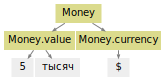

In [14]:
from yargy.predicates import eq, type, dictionary


Money = fact(
    'Money',
    ['value', 'currency']
)
MONEY = rule(
    rule(
        type('INT'),
        dictionary({
            'тысяча',
            'миллион'
        })
    ).interpretation(
        Money.value
    ),
    eq('$').interpretation(
        Money.currency
    )
).interpretation(
    Money
)

parser = Parser(MONEY)
match = parser.match('5 тысяч$')
match.tree.as_dot

В `Money.value` два слова:

In [15]:
match.fact

Money(
    value='5 тысяч',
    currency='$'
)

Когда под вершиной-атрибутом смесь из токенов и вершин-конструктов, интерпретация кидает `TypeError`:

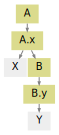

In [16]:
from yargy.predicates import true


A = fact(
    'A',
    ['x']
)
B = fact(
    'B',
    ['y']
)
RULE = rule(
    true(),
    true().interpretation(
        B.y
    ).interpretation(
        B
    )
).interpretation(
    A.x
).interpretation(
    A
)

parser = Parser(RULE)
match = parser.match('X Y')
match.tree.as_dot

In [17]:
# match.fact Будет TypeError

Если под вершиной-атрибутом другая вершина-атрибут, нижняя просто исчезает:

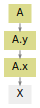

In [18]:
from yargy.predicates import true


A = fact(
    'A',
    ['x', 'y']
)
RULE = true().interpretation(
    A.x
).interpretation(
    A.y
).interpretation(A)

parser = Parser(RULE)
match = parser.match('X')
match.tree.as_dot

"X" попадёт в `A.y`, не в `A.x`:

In [19]:
match.fact

A(
    x=None,
    y='X'
)

Что если под вершиной-конструктом несколько одинаковых вершин-атрибутов? Самый правый атрибут перезаписывает все остальные:

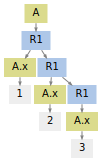

In [20]:
A = fact(
    'A',
    ['x']
)
RULE = true().interpretation(
    A.x
).repeatable().interpretation(
    A
)

parser = Parser(RULE)
match = parser.match('1 2 3')
match.tree.normalized.as_dot

В `A.x` попадёт "3":

In [21]:
match.fact

A(
    x='3'
)

Но бывает нужно сохранить содержание всех повторяющихся вершин-атрибутов, не только самой правой. Помечаем поле как `repeatable`:

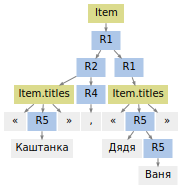

In [22]:
from yargy import not_


Item = fact(
    'Item',
    [attribute('titles').repeatable()]
)

TITLE = rule(
    '«',
    not_(eq('»')).repeatable(),
    '»'
)
ITEM = rule(
    TITLE.interpretation(
        Item.titles
    ),
    eq(',').optional()
).repeatable().interpretation(
    Item
)

parser = Parser(ITEM)
text = '«Каштанка», «Дядя Ваня»'
match = parser.match(text)
match.tree.as_dot

«Дядя Ваня» не перезапишет «Каштанка», они оба окажутся в `Item.titles`:

In [23]:
match.fact

Item(
    titles=['«Каштанка»',
     '«Дядя Ваня»']
)

Остался последний неочевидный случай, когда ребёнок вершины-конструктора, другая вершина-конструктор. Такая ситуация возникает при использовании рекурсивных грамматик. В примере ребёнок вершины `Item` другая вершина `Item`:

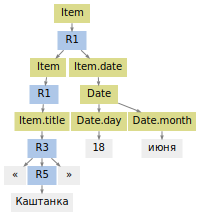

In [24]:
from yargy import forward, or_

Item = fact(
    'Item',
    ['title', 'date']
)

ITEM = forward().interpretation(
    Item
)
ITEM.define(or_(
    TITLE.interpretation(
        Item.title
    ),
    rule(ITEM, TITLE),
    rule(
        ITEM,
        DATE.interpretation(
            Item.date
        )
    )
))

parser = Parser(ITEM)
text = '«Каштанка» 18 июня'
match = parser.match(text)
match.tree.as_dot

В ходе интерпретации появится два объекта: `Item(title='«Каштанка»', date=None)` и `Item(title=None, date=Date('18', 'июня'))`. В конце произойдёт слияние:

In [25]:
match.fact

Item(
    title='«Каштанка»',
    date=Date(
        year=2017,
        month='июня',
        day='18'
    )
)

## Нормализация

В Yargy реализованы четыре основных метода для нормализации: `normalized`, `inflected`, `custom` и `const`. `normalized` возвращает нормальную форму слова, соответствует `normal_form` в Pymorphy2:

In [26]:
DATE = rule(
    DAY.interpretation(
        Date.day
    ),
    MONTH_NAME.interpretation(
        Date.month
    ),
    YEAR.interpretation(
        Date.year
    )
).interpretation(
    Date
)

parser = Parser(DATE)
match = parser.match('8 июня 2015')
match.fact

Date(
    year='2015',
    month='июня',
    day='8'
)

С `normalized` слово "июня" меняется на "июнь":

In [27]:
DATE = rule(
    DAY.interpretation(
        Date.day
    ),
    MONTH_NAME.interpretation(
        Date.month.normalized()
    ),
    YEAR.interpretation(
        Date.year
    )
).interpretation(
    Date
)

parser = Parser(DATE)
match = parser.match('8 июня 2015')
match.fact

Date(
    year='2015',
    month='июнь',
    day='8'
)

Если в `normalized` попадает несколько токенов, каждый приводится к нормальной форме без согласования:

In [28]:
from yargy.interpretation import fact
from yargy.predicates import normalized
from IPython.display import display


Geo = fact(
    'Geo',
    ['name']
)

RULE = rule(
    normalized('Красная'),
    normalized('площадь')
).interpretation(
    Geo.name.normalized()
).interpretation(
    Geo
)

parser = Parser(RULE)
for match in parser.findall('на Красной площади'):
    display(match.fact)

Geo(
    name='красный площадь'
)

Особым образом ведёт себя `normalized`, когда идёт после газеттира. Результат нормализации — ключ газеттира:

In [29]:
from yargy.pipelines import morph_pipeline

RULE = morph_pipeline([
    'красная площадь',
    'первомайская улица'
]).interpretation(
    Geo.name.normalized()
).interpretation(
    Geo
)

parser = Parser(RULE)
for match in parser.findall('c Красной площади на Первомайскую улицу'):
    display(match.fact)

Geo(
    name='красная площадь'
)

Geo(
    name='первомайская улица'
)

`inflected` склоняет слово, соответствует методу `inflect` в Pymorphy2:

In [30]:
from yargy.interpretation import fact
from yargy.predicates import gram

Name = fact(
    'Name',
    ['first']
)

NAME = gram('Name').interpretation(
    Name.first.inflected()
).interpretation(
    Name
)

parser = Parser(NAME)
for match in parser.findall('Саше, Маше, Вадиму'):
    display(match.fact)

Name(
    first='саша'
)

Name(
    first='маша'
)

Name(
    first='вадим'
)

`inflected` принимает набор граммем:

In [31]:
NAME = gram('Name').interpretation(
    Name.first.inflected({'accs', 'plur'})  # винительный падеж, множественное число
).interpretation(
    Name
)

parser = Parser(NAME)
for match in parser.findall('Саша, Маша, Вадим'):
    display(match.fact)

Name(
    first='саш'
)

Name(
    first='маш'
)

Name(
    first='вадимов'
)

`custom` применяет к слову произвольную функцию:

In [32]:
from yargy.interpretation import fact
from yargy.predicates import type

Float = fact(
    'Float',
    ['value']
)


INT = type('INT')
FLOAT = rule(
    INT,
    '.',
    INT
).interpretation(
    Float.value.custom(float)
).interpretation(
    Float
)

parser = Parser(FLOAT)
match = parser.match('3.1415')
match.fact

Float(
    value=3.1415
)

`custom` может применяться вместе с `normalized`. Тогда слово начала ставится в нормальную форму, потом к нему применяется функция:

In [33]:
MONTHS = {
    'январь': 1,
    'февраль': 2,
    'март': 3,
    'апрель': 4,
    'мая': 5,
    'июнь': 6,
    'июль': 7,
    'август': 8,
    'сентябрь': 9,
    'октябрь': 10,
    'ноябрь': 11,
    'декабрь': 12
}

DATE = rule(
    DAY.interpretation(
        Date.day.custom(int)
    ),
    MONTH_NAME.interpretation(
        Date.month.normalized().custom(MONTHS.__getitem__)
    ),
    YEAR.interpretation(
        Date.year.custom(int)
    )
).interpretation(
    Date
)

parser = Parser(DATE)
match = parser.match('8 июня 2015')
match.fact

Date(
    year=2015,
    month=6,
    day=8
)

`const` просто заменяет слово или словосочетания фиксированным значением:

In [34]:
Era = fact(
    'Era',
    ['value']
)

BC = morph_pipeline([
    'до нашей эры',
    'до н.э.'
]).interpretation(
    Era.value.const('BC')
)
AD = morph_pipeline([
    'наша эра',
    'н.э.'
]).interpretation(
    Era.value.const('AD')
)
ERA = or_(
    BC,
    AD
).interpretation(
    Era
)

parser = Parser(ERA)
for match in parser.findall('наша эра, до н.э.'):
    display(match.fact)

Era(
    value='AD'
)

Era(
    value='BC'
)

## Согласование

В Yargy реализовано четыре типа согласований: `gender_relation` — согласование по роду, `number_relation` — по числу, `case_relation` — по падежу, `gnc_relation` — по роду, числу и падежу. Метод `match` указывает согласование:

Name(
    first='саша',
    last='иванова'
)

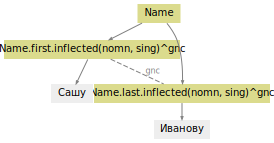

In [35]:
from yargy.relations import gnc_relation

Name = fact(
    'Name',
    ['first', 'last']
)

gnc = gnc_relation()

NAME = rule(
    gram('Name').interpretation(
        Name.first.inflected()
    ).match(gnc),
    gram('Surn').interpretation(
        Name.last.inflected()
    ).match(gnc)
).interpretation(
    Name
)

parser = Parser(NAME)
match = parser.match('Сашу Иванову')
display(match.fact)
display(match.tree.as_dot)

`main` указывает на главное слово во фразе. По-умолчанию главное слово — самое левое:

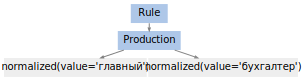

In [36]:
from yargy.relations import main

POSITION = rule(
    normalized('главный'),
    main(normalized('бухгалтер'))
)

POSITION.as_dot

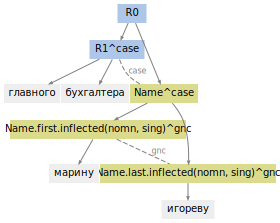

In [37]:
from yargy.relations import case_relation

case = case_relation()

PERSON = rule(
    POSITION.match(case),
    NAME.match(case)
)


parser = Parser(PERSON)
assert not parser.match('главного бухгалтер марину игореву')

match = parser.match('главного бухгалтера марину игореву')
match.tree.as_dot